___
# k Nearest Neighbors Models
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, \
recall_score, precision_score, f1_score

### Examine data

In [2]:
# Load data
df = pd.read_csv('../data/merged_pulls.csv')
transactions = pd.read_csv('../data/merged_logs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422 entries, 0 to 2421
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time_pulled    2422 non-null   object
 1   fullname       1976 non-null   object
 2   titles         2422 non-null   object
 3   times_created  2422 non-null   object
 4   anchors        2252 non-null   object
 5   subreddit      2422 non-null   object
dtypes: object(6)
memory usage: 113.7+ KB


In [3]:
# Checking that our target vector is a binary classification
df['subreddit'].unique()

array(['nfl', 'nhl'], dtype=object)

In [4]:
# Assign binary values for target variable
df['subreddit'] = df['subreddit'].map({'nfl': 0, 'nhl': 1})

___
# Null Model
___

In [5]:
print(f'For a classification model, our baseline model is the distribution between \
the two classes.  \nThe NFL is about {round(df['subreddit'].value_counts(normalize=True)[0] * 100, 2)} %. \
of the posts, while the NHL is the remaining {round(df['subreddit'].value_counts(normalize=True)[1] * 100 ,2)} %.')

For a classification model, our baseline model is the distribution between the two classes.  
The NFL is about 62.18 %. of the posts, while the NHL is the remaining 37.82 %.


___
# 03 - kNN with CVEC
___

### Prepare Data for Preprocessing

In [6]:
# Creating matrix
X = df['titles']
y = df['subreddit']

In [7]:
X.head()

0     Comparative offensive line ratings &amp; rank...
1     Most receiving yards through a players’ first...
2    "CapWages" &gt; "PuckPedia" (CapFriendly subst...
3                            "Hey, how's your mother?"
4    "The original [LeBreton arena] deal was really...
Name: titles, dtype: object

In [8]:
# Split data - test size 25%, random state 27 and stratify as our data is slightly stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27, stratify=y)

### Pipeline and GridSearch

In [9]:
# Building a pipeline for kNN with CVEC

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [10]:
# Setting up hyperparameters to explore

pipe1_parameters = {
    'cvec__max_features': range(3500, 5500, 500),
    'cvec__stop_words': ['english'],
    'cvec__min_df': [1, 3], 
    'cvec__max_df': [0.3, 1],
    'knn__n_neighbors': range(3, 5, 1),
    'knn__weights': ('distance', 'uniform'),
    'knn__algorithm': ('auto', 'ball_tree'),
    }    

### Instantiate and fit model

In [11]:
# Grid Search for best configuration
gs = GridSearchCV(pipe1, 
                 pipe1_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs.fit(X_train, y_train)

C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, r

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.3, 1],
                         'cvec__max_features': range(3500, 5500, 500),
                         'cvec__min_df': [1, 3],
                         'cvec__stop_words': ['english'],
                         'knn__algorithm': ('auto', 'ball_tree'),
                         'knn__n_neighbors': range(3, 5),
                         'knn__weights': ('distance', 'uniform')})

### Evaluate

In [12]:
# The GridSearch best results
pipe1_best_params = pd.Series(gs.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs.best_score_ * 100, 2)} %.')
print('================================================')
pipe1_best_params

The GridSearch best score was 62.83 %.


cvec__max_df              0.3
cvec__max_features       4500
cvec__min_df                1
cvec__stop_words      english
knn__algorithm           auto
knn__n_neighbors            3
knn__weights          uniform
dtype: object

In [13]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs.score(X_test, y_test) *100, 2)} %.')

Training data score: 85.13 %.
Testing data score: 65.84 %.


In [14]:
# Evaluate predictions
preds1 = gs.predict(X_test)

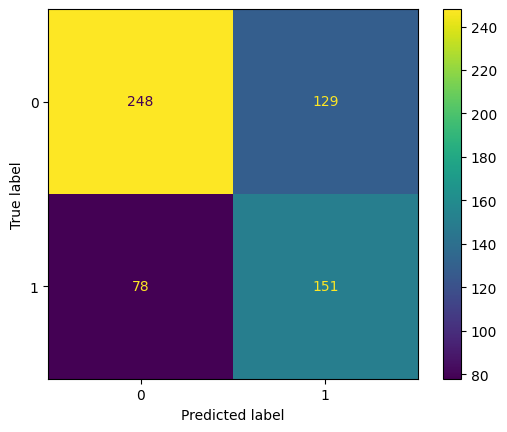

In [15]:
# View them in a confustion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds1),
                             display_labels=gs.classes_)

cmd.plot();

In [16]:
# Common Metrics

# Specificity
spec = tn / (tn+fp)
print(f'The specificity was {round(spec * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

The specificity was 65.78 %.
**************************************
The sensitivity was 65.94 %.
**************************************
The precision was 53.93 %.
**************************************
The F1 score was 59.33 %.
**************************************


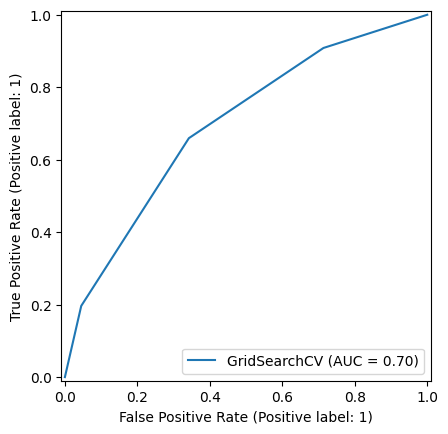

In [17]:
# Roc Curve
RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.legend;
plt.show();

In [18]:
# The curve is pretty average, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds1) * 100, 2)} %. \
     \nThis is a ok score, 1.0 being the best and 0.5 being the worst. \
     \nThis leaves room for improvement.')

The ROC AUC score is 65.86 %.      
This is a ok score, 1.0 being the best and 0.5 being the worst.      
This leaves room for improvement.


### kNN CVEC Evaluation

The kNN with CVEC transformer did not do well.  This model is measuring the distance between the points.  Adjusting the hyper parameters did not do much to improve the model.  If anything it was a struggle to avoid sinking as the ROC AUC score delved as low as 51%.  There was an instance were specificity was 100% and everything was predicted to be negatives.

Will have a look at the model with a TVEC transfomer before turning to other models.

___
# 04 - kNN with TVEC
___

In [19]:
# Building a pipeline for kNN with TVEC

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [20]:
# Setting up hyperparameters to explore

pipe2_parameters = {
    'tvec__max_features': range(500, 3500, 500),
    'tvec__min_df': [1, 4],
    'tvec__max_df': np.linspace(0.01, 0.30, 10),
    'tvec__stop_words': [None, 'english'],
    'knn__n_neighbors': range(5, 10, 1),
    'knn__weights': ('distance', 'uniform'),
    'knn__algorithm': ('auto', 'kd_tree')
}    

In [21]:
# Grid Search for best configuration
gs2 = GridSearchCV(pipe2, 
                 pipe2_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ('auto', 'kd_tree'),
                         'knn__n_neighbors': range(5, 10),
                         'knn__weights': ('distance', 'uniform'),
                         'tvec__max_df': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                         'tvec__max_features': range(500, 3500, 500),
                         'tvec__min_df': [1, 4],
                         'tvec__stop_words': [None, 'english']})

### Evaluate

In [22]:
# The GridSearch best results
pipe2_best_params = pd.Series(gs2.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs2.best_score_ * 100, 2)} %.')
print('================================================')
pipe2_best_params

The GridSearch best score was 71.91 %.


knn__algorithm            auto
knn__n_neighbors             9
knn__weights           uniform
tvec__max_df          0.106667
tvec__max_features        3000
tvec__min_df                 1
tvec__stop_words       english
dtype: object

In [23]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs2.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs2.score(X_test, y_test) *100, 2)} %.')

Training data score: 80.23 %.
Testing data score: 77.23 %.


In [24]:
# Evaluate predictions
preds2 = gs2.predict(X_test)

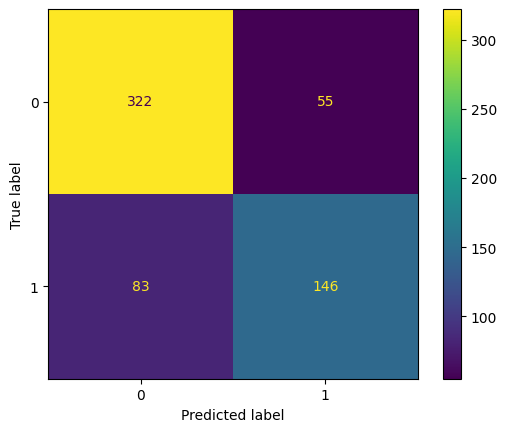

In [25]:
# View them in a confustion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

cmd2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds2),
                             display_labels=gs2.classes_)

cmd2.plot();

In [26]:
# Common Metrics

# Specificity
spec2 = tn2 / (tn2+fp2)
print(f'The specificity was {round(spec2 * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

The specificity was 85.41 %.
**************************************
The sensitivity was 63.76 %.
**************************************
The precision was 72.64 %.
**************************************
The F1 score was 67.91 %.
**************************************


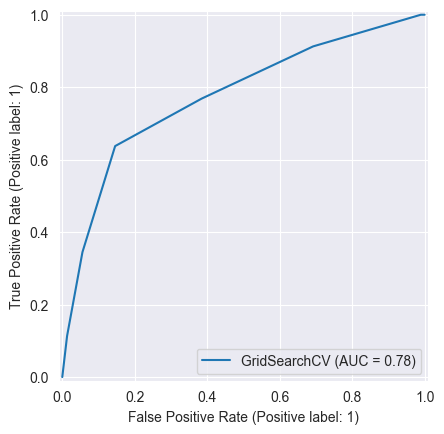

In [30]:
# Roc Curve
sns.set_style('darkgrid')
RocCurveDisplay.from_estimator(gs2, X_test, y_test)
plt.legend;
plt.savefig('../assets/knn_tvec_roc_auc.jpg');
plt.show();

In [28]:
# The curve is quite squre, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds2) * 100, 2)} %. \
     \nThis is a worse score, 1.0 being the best and 0.5 being the worst.')

The ROC AUC score is 74.58 %.      
This is a worse score, 1.0 being the best and 0.5 being the worst.


### kNN TVEC Evaluation

This model has had the best performance of the first four.  It's Roc AUC score is a just under 75%.  The F1 score is the strongest at just under 68%, doing a better job of diffentiating between the classes. This is apparent in the confusion matrix with more true postives and true negatives present.

Let's see how it does compared to a Multinomial Naive Bayes model.